# 1. Install Dependencies and Setup

In [1]:
pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
certifi                      2024.7.4
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.2
decorator                    5.1.1
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.53.1
gast                         0.6.0
google-pasta                 0.2.0
grpcio                       1.65.1
h5py                         3.11.0
idna                         3.7
ipykernel                    6.29.5
ipython                      8.26.0
jedi                         0.19.1
jupyter_client               8.6.2
jupyter_core                 5.7.2
keras                        3.4.1
kiwisolver                   1.4.5
li

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [51]:
import cv2
import imghdr

In [7]:
data_dir = 'data' 

In [52]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [53]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [55]:
import numpy as np
from matplotlib import pyplot as plt

In [56]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [57]:
data_iterator = data.as_numpy_iterator()

In [58]:
batch = data_iterator.next()

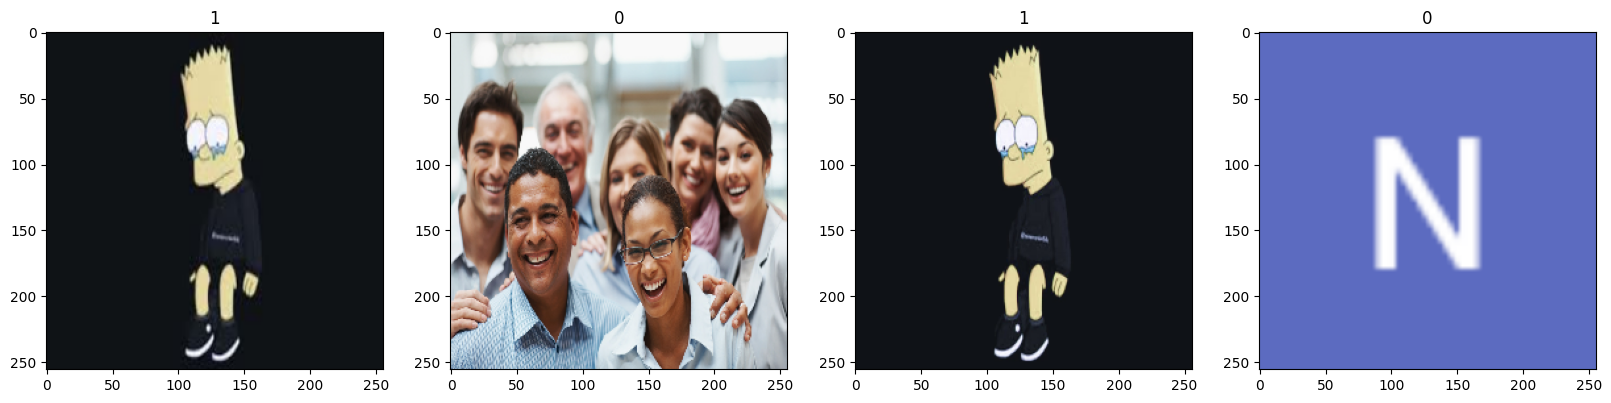

In [59]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [60]:
data = data.map(lambda x,y: (x/255, y))

In [61]:
data.as_numpy_iterator().next()

(array([[[[0.5064951 , 0.5692402 , 0.52610296],
          [0.5213235 , 0.58406866, 0.54093134],
          [0.5355392 , 0.5982843 , 0.54901963],
          ...,
          [0.9655637 , 0.96164215, 0.953799  ],
          [0.96862745, 0.9647059 , 0.95686275],
          [0.96862745, 0.9647059 , 0.95686275]],
 
         [[0.5064951 , 0.5692402 , 0.52610296],
          [0.5213235 , 0.58406866, 0.54093134],
          [0.5355392 , 0.5982843 , 0.54901963],
          ...,
          [0.9648684 , 0.96094686, 0.9531037 ],
          [0.96544886, 0.9615273 , 0.95368415],
          [0.96544886, 0.9615273 , 0.95368415]],
 
         [[0.5064951 , 0.5692402 , 0.52610296],
          [0.5213235 , 0.58406866, 0.54093134],
          [0.5355392 , 0.5982843 , 0.54901963],
          ...,
          [0.9647059 , 0.9607843 , 0.9529412 ],
          [0.9647059 , 0.9607843 , 0.9529412 ],
          [0.9647059 , 0.9607843 , 0.9529412 ]],
 
         ...,
 
         [[0.8213654 , 0.6761984 , 0.6055413 ],
          [0.82354

# 5. Split Data

In [62]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [63]:
train_size

7

In [64]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [65]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [67]:
model = Sequential()

In [68]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [69]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [71]:
logdir='logs'

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [73]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 700ms/step - accuracy: 0.4525 - loss: 1.2053 - val_accuracy: 0.7656 - val_loss: 0.6548
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 680ms/step - accuracy: 0.5708 - loss: 0.6918 - val_accuracy: 0.7344 - val_loss: 0.6594
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 665ms/step - accuracy: 0.6878 - loss: 0.6453 - val_accuracy: 0.8438 - val_loss: 0.5650
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 677ms/step - accuracy: 0.7938 - loss: 0.5251 - val_accuracy: 0.8438 - val_loss: 0.4367
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 747ms/step - accuracy: 0.8280 - loss: 0.4464 - val_accuracy: 0.8906 - val_loss: 0.2795
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 675ms/step - accuracy: 0.8340 - loss: 0.3570 - val_accuracy: 0.8750 - val_loss: 0.3035
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 690ms/step - accuracy: 0.8405 - loss: 0.3442 - val_accuracy: 0.9688 - val_loss: 0.3198
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 761ms/step - accuracy: 0.9354 - loss: 0.2875 - val_accuracy: 0.9688 - val_loss: 0.1422
Ep

# 8. Plot Performance

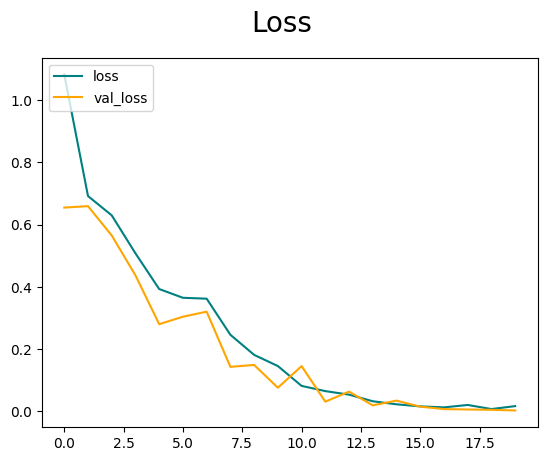

In [74]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

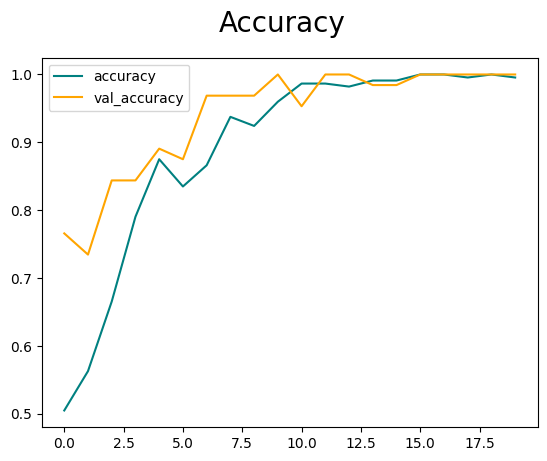

In [75]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [76]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [77]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [78]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


In [79]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [80]:
import cv2

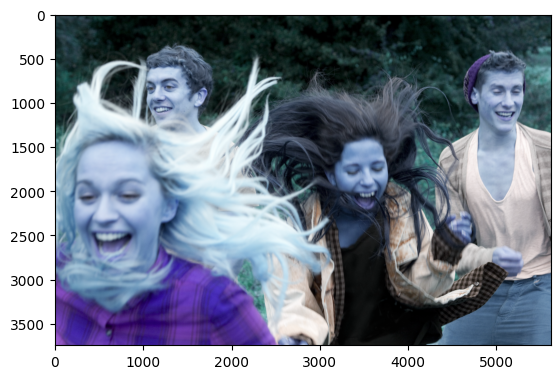

In [82]:
img = cv2.imread('happy_example.jpg')
plt.imshow(img)
plt.show()

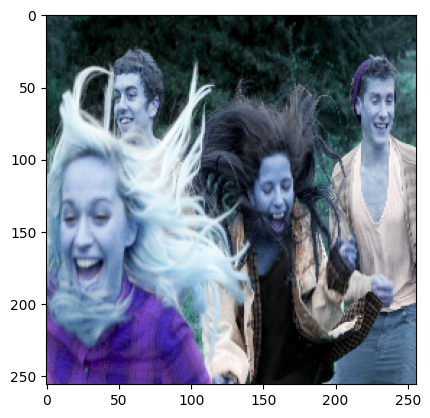

In [83]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [84]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


In [85]:
yhat

array([[0.28401625]], dtype=float32)

In [86]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [88]:
from tensorflow.keras.models import load_model

In [89]:
model.save(os.path.join('models','imageclassifier.h5'))
model.save(os.path.join('models','imageclassifier.keras'))

In [90]:
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

In [92]:
img = cv2.imread('sad_example.jpg')
resize = tf.image.resize(img, (256,256))
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))
if yhat_new > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class is Sad
